### <font color='green'> Green Energy Forecasting</font>

#### In this problem we need to see if we can predict the total energy demand of the country in the near future, we have a good database, our database has 94991 values and 3 columns, here we will use the "train_IxoE5JN.csv" database that was made available for use, below you will see an analysis of the data, the processing of that data, and the use of machine learning models to achieve our goal.


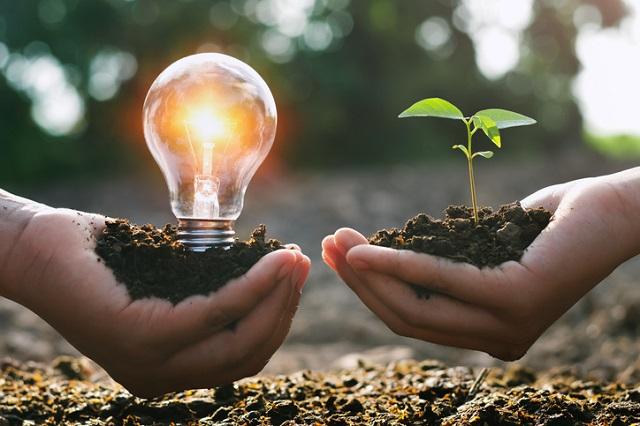

## <font color='green'>Importing Libraries</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## <font color='green'> Setting Theme </font>

In [2]:
sns.set_style("darkgrid")

matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["figure.figsize"] = (10,6)
matplotlib.rcParams["figure.facecolor"] = "#00000000"

## <font color='green'>Importing Dataset</font>

#### Here we are reading the train database using the name "df" in the variable and test database using the name "test_df".

In [3]:
df = pd.read_csv("train_IxoE5JN.csv")
test_df = pd.read_csv("test_WudNWDM.csv")

**Review Dataset**

In [4]:
df.head()

row_id             datetime       energy
0       1  2008-03-01 00:00:00  1259.985563
1       2  2008-03-01 01:00:00  1095.541500
2       3  2008-03-01 02:00:00  1056.247500
3       4  2008-03-01 03:00:00  1034.742000
4       5  2008-03-01 04:00:00  1026.334500

Our train dataset has been started from `1st Mar 2008`.

In [5]:
test_df.head()

row_id             datetime
0   94993  2019-01-01 00:00:00
1   94994  2019-01-01 01:00:00
2   94995  2019-01-01 02:00:00
3   94996  2019-01-01 03:00:00
4   94997  2019-01-01 04:00:00

Our test dataset has been started from `1st Jan 2019`.The train dataset contains energy column but test dataset does not contains energy column because we need to forecast energy details for test dataset.

## <font color='green'>Exploratory data analysis</font>

Now, I will explore the data to gain insights about the data.

In [6]:
# view dimensions of dataset

print('Number of rows and columns in train dataset are:',df.shape)
print('Number of rows and columns in test dataset are:', test_df.shape)

Number of rows and columns in train dataset are: (94992, 3)
Number of rows and columns in test dataset are: (26304, 2)


In [7]:
# view summary of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


Here we see dataset contains missing values in our target column.

we should drop the `row_id` feature variable from the dataset because it doesn't help us to get our goal . So, we should drop it as follows-

In [8]:
def drop_column(dataset):
    dataset.drop(["row_id"],axis=1,inplace=True)

In [9]:
drop_column(df)

In [10]:
drop_column(test_df)

**Missing Values**

In [11]:
# check missing values 
df.isnull().sum()

datetime       0
energy      1900
dtype: int64

We have total of 1900 missing values in energy column.

**Descriptive Statistics**

In [12]:
# descriptive statistics about features

df.describe()

energy
count  93092.000000
mean    1702.995014
std      369.322103
min      866.388600
25%     1431.541100
50%     1654.465800
75%     1935.993450
max     3374.399600

Here we see mean and median quaite comparable. May be we will  get normal distribution for energy column.

**Data Types**

In [13]:
# Checking data types

df.dtypes

datetime     object
energy      float64
dtype: object

Here datetime is in object format. We need to change its datatype to datetime.

In [14]:
#converting datetime to datetime format
def convert_datatype(dataset):
    
    dataset["datetime"] = pd.to_datetime(dataset["datetime"])

In [15]:
convert_datatype(df)
convert_datatype(test_df)

**Explore Target Variable**

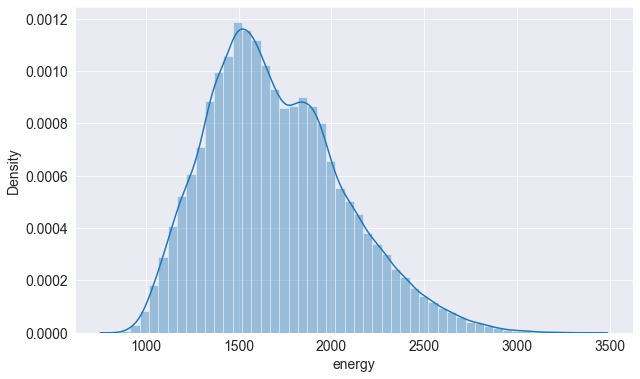

In [16]:
#Visualize density of energy variable

sns.distplot(df["energy"]);

Here we see almost normal distribution type but there are some outliers present in the column. Let's apply log function to see if we can make more accurate normal distribution or not.

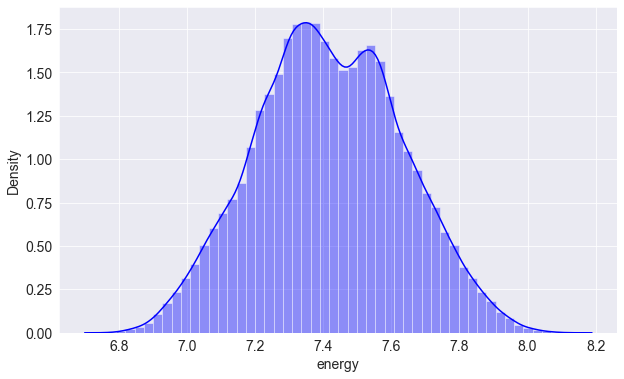

In [17]:
#Visualize density after applying log function

sns.distplot(np.log(df["energy"]),color="b");

Here we can see two peak in the graph otherwise it looks like gussian distribution.

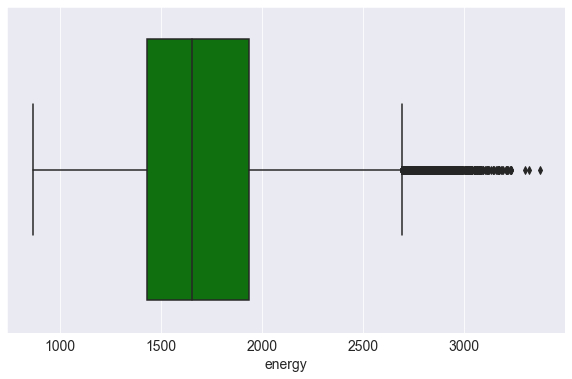

In [18]:
#checking outliers

sns.boxplot(df["energy"],color="green");

We clearly see our target variable has outliers. Let's see inter quartile range to know from where our outliers has been started.

In [19]:
# Find out inter quartile range

IQR = df.energy.quantile(0.75) - df.energy.quantile(0.25)
Upper_fence = df.energy.quantile(0.75) + (IQR*3)

print("Energy outliers are values from {}".format(Upper_fence))

Energy outliers are values from 3449.3505


## <font color='green'>Data Visualization</font>

**Datetime**

In [20]:
print('Time series start time: "{}" and end time: "{}"'.format(df['datetime'].min(), df['datetime'].max()))
print('Time series start time: "{}" and end time: "{}"'.format(test_df['datetime'].min(), test_df['datetime'].max()))

Time series start time: "2008-03-01 00:00:00" and end time: "2018-12-31 23:00:00"
Time series start time: "2019-01-01 00:00:00" and end time: "2021-12-31 23:00:00"


In [21]:
df["datetime"].max() - df["datetime"].min()

Timedelta('3957 days 23:00:00')

We have almost 4000 days data for training.

Let's extract hour, day, week, month, year from datetime feature.

In [22]:
from datetime import datetime
def split_date(dataset):
    dataset["Year"] = dataset.datetime.dt.year
    dataset["Month"] = dataset.datetime.dt.month
    dataset["DayOfMonth"] = dataset.datetime.dt.day
    dataset["DayOfWeek"] = dataset.datetime.dt.day_name()
    dataset["WeekOfYear"] = dataset.datetime.dt.isocalendar().week
    dataset["Hour"] = dataset.datetime.dt.hour

In [23]:
split_date(df)
split_date(test_df)

In [24]:
df.head()

datetime       energy  Year  Month  DayOfMonth DayOfWeek  \
0 2008-03-01 00:00:00  1259.985563  2008      3           1  Saturday   
1 2008-03-01 01:00:00  1095.541500  2008      3           1  Saturday   
2 2008-03-01 02:00:00  1056.247500  2008      3           1  Saturday   
3 2008-03-01 03:00:00  1034.742000  2008      3           1  Saturday   
4 2008-03-01 04:00:00  1026.334500  2008      3           1  Saturday   

   WeekOfYear  Hour  
0           9     0  
1           9     1  
2           9     2  
3           9     3  
4           9     4

Now we can drop datetime column from dataframe and start visualize the dataset.

In [25]:
def drop_column(dataset):
    dataset.drop(["datetime"],axis=1,inplace=True)

In [26]:
drop_column(df)
drop_column(test_df)

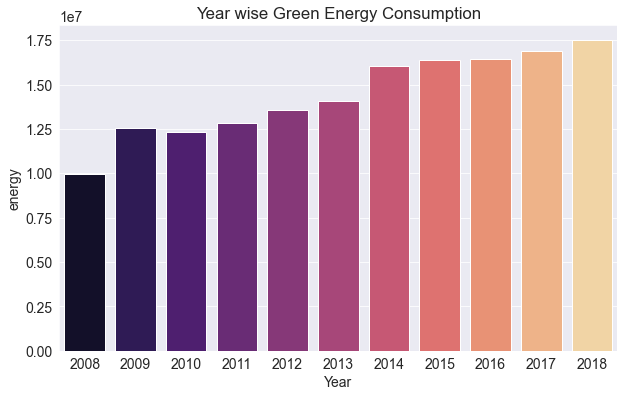

In [27]:
year_energy = df.groupby('Year').sum()
sns.barplot(data=year_energy,x=year_energy.index,y="energy",palette="magma")

plt.title("Year wise Green Energy Consumption");

Here we see, every year the consumption of green enegy is incresing.

In [28]:
plt.figure(figsize=(15,8))
month_energy = df.groupby(["Month","Year"],as_index=False).mean()

fig = px.line(month_energy,x="Month",y="energy",
       color="Year",
       title="Energy Consumption per year wise")
fig.show()

<Figure size 1080x576 with 0 Axes>

- From the above line chart we can conclude that from May to August green energy consumption is showing up.
- In Mar and October the line is showing downward trend, it means in these month we don't generate green energy much.

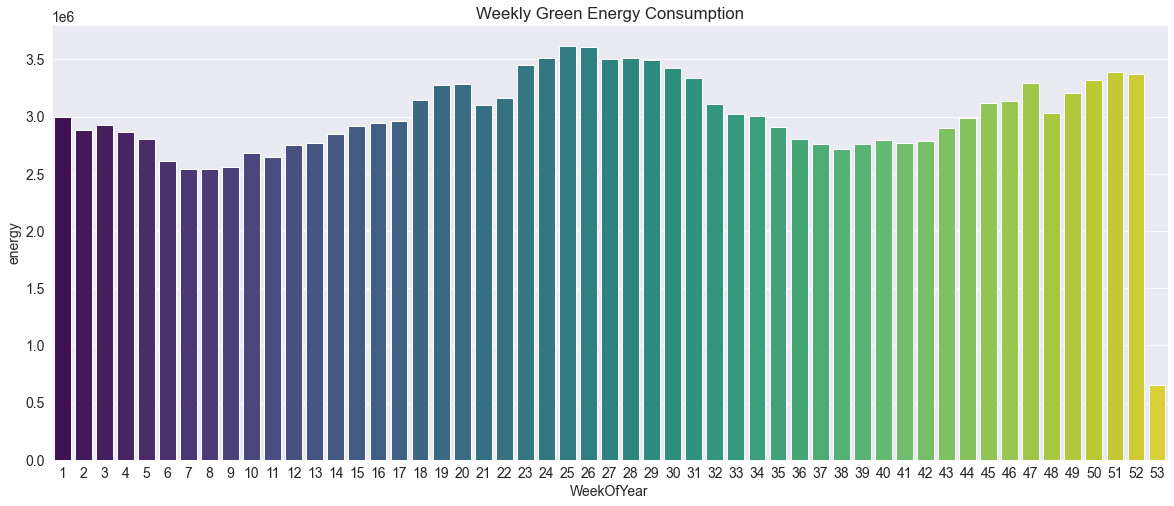

In [29]:
plt.figure(figsize=(20,8))
w_energy = df.groupby('WeekOfYear').sum()
sns.barplot(data=w_energy,x=w_energy.index,y="energy",palette="viridis")

plt.title("Weekly Green Energy Consumption");

Here we found a very surprising thing that at last week of every year the green energy consumption is not exceed 70000.

In [30]:
plt.figure(figsize=(15,8))
w_energy = df.groupby(["WeekOfYear","Year"],as_index=False).mean()

fig = px.line(w_energy,x="WeekOfYear",y="energy",
       color="Year",
       title="Weekly Energy Consumption per year wise")
fig.show()

<Figure size 1080x576 with 0 Axes>

Here the line is wavy shape and we can conclude that from 20th week to 30th week, energy consumption is always up.

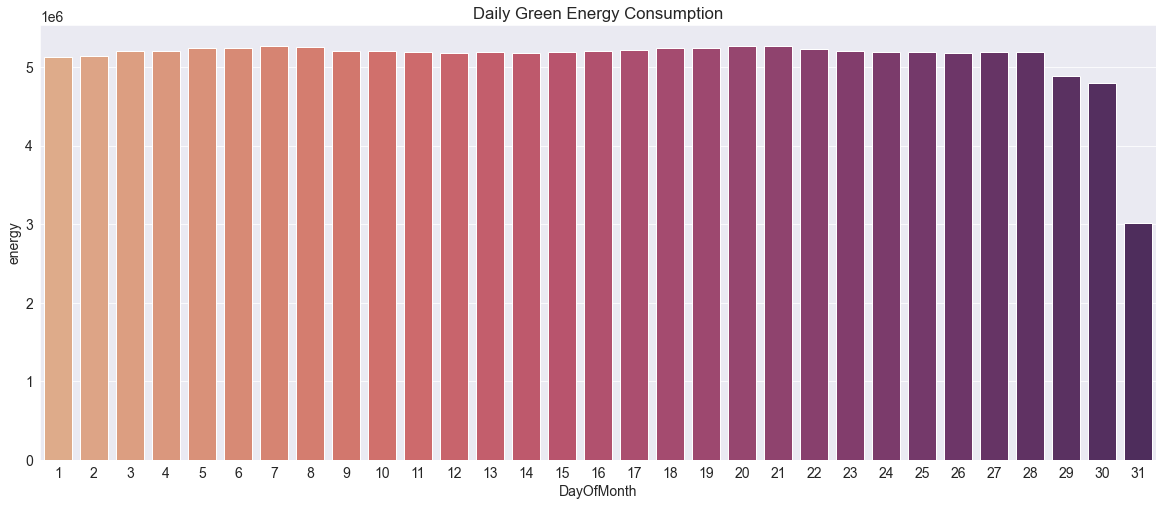

In [31]:
plt.figure(figsize=(20,8))
w_energy = df.groupby('DayOfMonth').sum()
sns.barplot(data=w_energy,x=w_energy.index,y="energy",palette="flare")

plt.title("Daily Green Energy Consumption");

There is no such changes in energy consumption in dailywise however on 29th,30th and 31st of the month the consumption is low.

In [32]:
plt.figure(figsize=(15,8))
h_energy = df.groupby(["Hour","Year"],as_index=False).mean()

fig = px.line(h_energy,x="Hour",y="energy",
       color="Year",
       title="Hourly Energy Consumption per year wise")
fig.show()

<Figure size 1080x576 with 0 Axes>

From the above line chart We can summurize that from 8 AM to 9 PM energy consumption is always high as compared to 12 AM to 5 PM.

In [33]:
fig = px.pie(h_energy, values='energy', names='Hour',color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Here we see that from 12 AM to 5 AM energy consumption is almost 3.50%.

In [34]:
plt.figure(figsize=(15,8))
h_energy = df.groupby(["Hour","DayOfWeek"],as_index=False).mean()

fig = px.line(h_energy,x="Hour",y="energy",
       color="DayOfWeek",
       title="Hourly Energy Consumption per Day wise")
fig.show()

<Figure size 1080x576 with 0 Axes>

From the above line chart We can conclude that on Sunday and Monday, energy consumption is always low as compared to other days.

In [35]:
d_energy = df.groupby(["DayOfWeek"]).sum()
fig = px.pie(d_energy, values='energy', names=d_energy.index,color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Here we see that on Sunday and Monday energy consumption is low as compared to other days.

In [36]:
plt.figure(figsize=(15,8))
m_energy = df.groupby(["Hour","Month"],as_index=False).mean()

fig = px.line(m_energy,x="Hour",y="energy",
       color="Month",
       title="Hourly Energy Consumption per Month wise")
fig.show()

<Figure size 1080x576 with 0 Axes>

- In June and July, the energy consumption is always high.
- The energy consumption is very high  at 11 AM to 7 PM for November, December and January.

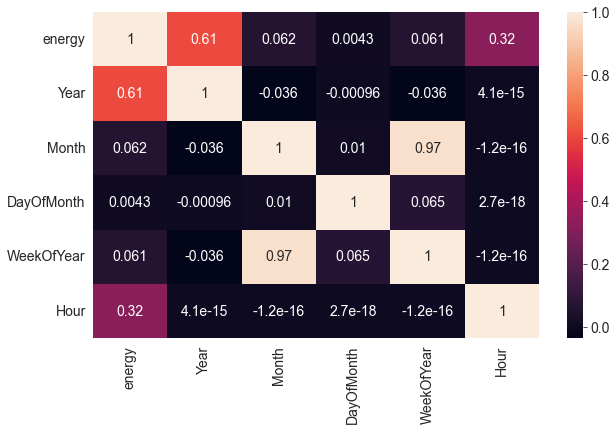

In [37]:
#checking correlation among different variables.

corr_df = df.corr()
sns.heatmap(corr_df,annot=True);

From the above correlation matrix We can say that Year is highly correlated with energy after this hour is correlated with energy.

**Summary of Exploratory Data analysis and Data Visualization**

- The dataset contains 95000 rows and 3 columns(`row_id','datetime`,`energy`)
- `Energy` is our target variable.
- The distribution shape of our target variable become almost gaussian distribution after applying log function.
- `Energy` column is contains 1900 missing values and also contains outliers also.
- From the visualization we can say the energy concumption is increasing year by year.
- Energy consumption is very high in `May`,`June`,`July` and `August`.
- If we see hourly wise consumption then we found that consumption rate is very low from 12 AM to 5 AM and very high from 8 AM to 7 PM.
- In daywise, except Sunday and Monday, energy consumption is same for other days. On sunday and Monday,consumption rate is quietly low.

## <font color='green'>Data Preprocessing</font>

**Missing Values**

In [38]:
df.isnull().sum()

energy        1900
Year             0
Month            0
DayOfMonth       0
DayOfWeek        0
WeekOfYear       0
Hour             0
dtype: int64

We have 1900 data points where null values are there.

In [39]:
df = df.dropna()

We used dropna function to remove all the null values.

In [40]:
df.isnull().sum()

energy        0
Year          0
Month         0
DayOfMonth    0
DayOfWeek     0
WeekOfYear    0
Hour          0
dtype: int64

Now our dataset set is free from Null values.

**Input and Target Columns**

In [41]:
df.columns

Index(['energy', 'Year', 'Month', 'DayOfMonth', 'DayOfWeek', 'WeekOfYear',
       'Hour'],
      dtype='object')

Here is all the columns of our dataset.

In [42]:
input_cols = ["Year","Month","DayOfMonth","DayOfWeek","WeekOfYear","Hour"]
target_col = "energy"

We seggregated all the columns into input columns and target column.

In [43]:
inputs = df[input_cols].copy()
targets = df[target_col].copy()
test_inputs = test_df[input_cols].copy()

Now we made copies of original dataset. If we mess up somewhere then again we come back and solve the problem.

In [44]:
num_cols = ["Year","Month","DayOfMonth","WeekOfYear","Hour"]
cat_col = ["DayOfWeek"]

We seggregated all the inputs columns into numerical columns and categorical column to performing feature engineering.

**Scaling**

In [45]:
scaler = MinMaxScaler().fit(inputs[num_cols],test_inputs[num_cols])

We used MinMaxScaler to perfoming scaling.

In [46]:
inputs[num_cols] = scaler.transform(inputs[num_cols])
test_inputs[num_cols] = scaler.transform(test_inputs[num_cols])

**Encoding Categorical Data**

In [47]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(inputs[cat_col],test_inputs[cat_col])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [48]:
encoded_cols = list(encoder.get_feature_names(cat_col))

In [49]:
inputs[encoded_cols] = encoder.transform(inputs[cat_col])
test_inputs[encoded_cols] = encoder.transform(test_inputs[cat_col])

In [50]:
test_inputs

Year  Month  DayOfMonth DayOfWeek  WeekOfYear      Hour  \
0       1.1    0.0         0.0   Tuesday    0.000000  0.000000   
1       1.1    0.0         0.0   Tuesday    0.000000  0.043478   
2       1.1    0.0         0.0   Tuesday    0.000000  0.086957   
3       1.1    0.0         0.0   Tuesday    0.000000  0.130435   
4       1.1    0.0         0.0   Tuesday    0.000000  0.173913   
...     ...    ...         ...       ...         ...       ...   
26299   1.3    1.0         1.0    Friday    0.980769  0.826087   
26300   1.3    1.0         1.0    Friday    0.980769  0.869565   
26301   1.3    1.0         1.0    Friday    0.980769  0.913043   
26302   1.3    1.0         1.0    Friday    0.980769  0.956522   
26303   1.3    1.0         1.0    Friday    0.980769  1.000000   

       DayOfWeek_Friday  DayOfWeek_Monday  DayOfWeek_Saturday  \
0                   0.0               0.0                 0.0   
1                   0.0               0.0                 0.0   
2                   0.0               0.0                 0.0   
3                   0.0               0.0                 0.0   
4                   0.0               0.0                 0.0   
...                 ...               ...                 ...   
26299               1.0               0.0                 0.0   
26300               1.0               0.0                 0.0   
26301               1.0               0.0                 0.0   
26302               1.0               0.0                 0.0   
26303               1.0               0.0                 0.0   

       DayOfWeek_Sunday  DayOfWeek_Thursday  DayOfWeek_Tuesday  \
0                   0.0                 0.0                1.0   
1                   0.0                 0.0                1.0   
2                   0.0                 0.0                1.0   
3                   0.0                 0.0                1.0   
4                   0.0                 0.0                1.0   
...                 ...                 ...                ...   
26299               0.0                 0.0                0.0   
26300               0.0                 0.0                0.0   
26301               0.0                 0.0                0.0   
26302               0.0                 0.0                0.0   
26303               0.0                 0.0                0.0   

       DayOfWeek_Wednesday  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
26299                  0.0  
26300                  0.0  
26301                  0.0  
26302                  0.0  
26303                  0.0  

[26304 rows x 13 columns]

In [51]:
X_train = inputs[num_cols+encoded_cols]
X_test = test_inputs[num_cols+encoded_cols]

Now our dataset is ready for training model.

In [52]:
X_train.head()

Year     Month  DayOfMonth  WeekOfYear      Hour  DayOfWeek_Friday  \
0   0.0  0.181818         0.0    0.153846  0.000000               0.0   
1   0.0  0.181818         0.0    0.153846  0.043478               0.0   
2   0.0  0.181818         0.0    0.153846  0.086957               0.0   
3   0.0  0.181818         0.0    0.153846  0.130435               0.0   
4   0.0  0.181818         0.0    0.153846  0.173913               0.0   

   DayOfWeek_Monday  DayOfWeek_Saturday  DayOfWeek_Sunday  DayOfWeek_Thursday  \
0               0.0                 1.0               0.0                 0.0   
1               0.0                 1.0               0.0                 0.0   
2               0.0                 1.0               0.0                 0.0   
3               0.0                 1.0               0.0                 0.0   
4               0.0                 1.0               0.0                 0.0   

   DayOfWeek_Tuesday  DayOfWeek_Wednesday  
0                0.0                  0.0  
1                0.0                  0.0  
2                0.0                  0.0  
3                0.0                  0.0  
4                0.0                  0.0

In [53]:
X_train.shape,X_test.shape

((93092, 12), (26304, 12))

Checked the shape because if number of variable is not same then we will get an error while predicting for test data. Here the variable number is same. So we ready to go.

**Splitting Data into training and validation set**

In [54]:
train_inputs,val_inputs,train_targets,val_targets = train_test_split(X_train,targets,test_size=0.2,random_state=42)

Splited the dataset into training and validation dataset and the test size is 20% of entire dataset.

## <font color='green'>Machine Learning Model</font>

## 1. Training (Linear Regression)

In [55]:
lin_model = LinearRegression().fit(train_inputs,train_targets)

In [56]:
lin_preds = lin_model.predict(val_inputs)

#Evaluvation: MSE
lin_rmse = mean_squared_error(lin_preds,val_targets,squared=False)

# R_square
lin_R_square = lin_model.score(val_inputs,val_targets)

print('The Mean Square Error(MSE) is: ',lin_rmse)
print('R square is :',lin_R_square)

The Mean Square Error(MSE) is:  255.67812664213318
R square is : 0.5143056534716111


Mean square error is 255 which seems good.

The model returns  R2  value of 51.43%, so it does not fit our data test very well.

In [57]:
#Checking Overfitting and underfitting
train_preds = lin_model.predict(train_inputs)
val_preds = lin_model.predict(val_inputs)


train_rmse = mean_squared_error(train_preds,train_targets,squared=False)
val_rmse = mean_squared_error(val_preds,val_targets,squared=False)
    
print('The RMSE loss for the training set is {:.4f}.'.format(train_rmse))
print('The RMSE loss for the validation set is {:.4f}.'.format(val_rmse))

The RMSE loss for the training set is 254.4138.
The RMSE loss for the validation set is 255.6781.


The training-set loss is 254.4138 while the test-set loss to be 255.6781. These two values are quite comparable. So, there is no question of overfitting.

**Model Validation**

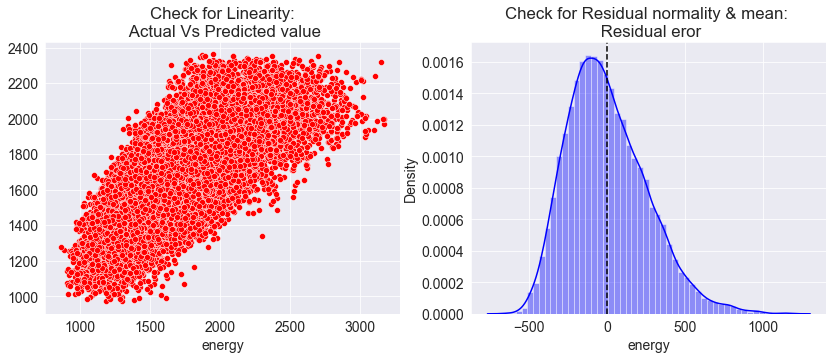

In [58]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(val_targets,lin_preds,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((val_targets - lin_preds),ax=ax,color='b')
ax.axvline((val_targets - lin_preds).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');


- In our model the actual vs predicted plot is linear.
- The residual mean is zero and residual error plot right skewed.

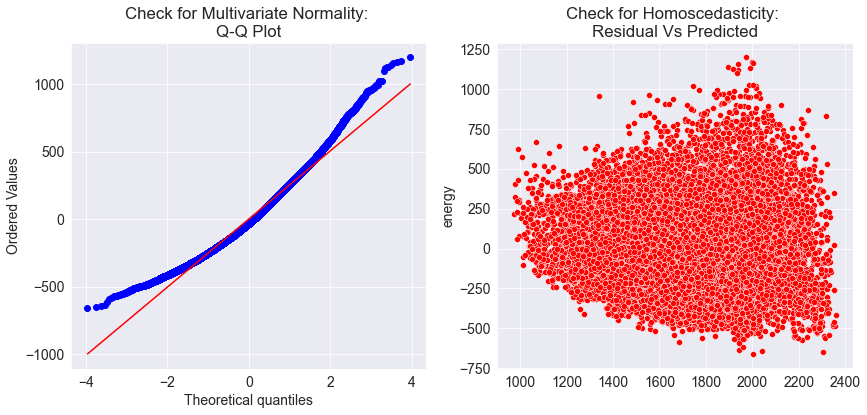

In [59]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((val_targets - lin_preds),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (val_targets - lin_preds), x= lin_preds, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

- Q-Q plot shows value greater than 500 trends to increase.
- The plot is exhibit heteroscedastic, error will insease after certian point.

In [60]:
# Check for Multicollinearity
#Variance Inflation Factor
VIF = 1/(1- lin_R_square)
VIF

2.0589080501919117

Variance inflation factor value is less than 5, so no multicollearity.

Our main goal is minimising the rmse so we will other machine learning model to check the RMSE.

**Some Usefull function**

In [61]:
def mse_and_r_square(model,preds):
    rmse = mean_squared_error(preds,val_targets,squared=False) 
    R_square = model.score(val_inputs,val_targets)
    
    
    print('The Mean Square Error(MSE) is: ',rmse)
    print('R square is:',R_square)

In [62]:
def check_fittings(model):
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)


    train_rmse = mean_squared_error(train_preds,train_targets,squared=False)
    val_rmse = mean_squared_error(val_preds,val_targets,squared=False)
    
    print('The RMSE loss for the training set is {:.4f}.'.format(train_rmse))
    print('The RMSE loss for the validation set is {:.4f}.'.format(val_rmse))

In [63]:
def check_linearity_residual_normality(preds):
    # Check for Linearity
    f = plt.figure(figsize=(14,5))
    ax = f.add_subplot(121)
    sns.scatterplot(val_targets,preds,ax=ax,color='r')
    ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

     # Check for Residual normality & mean
    ax = f.add_subplot(122)
    sns.distplot((val_targets - preds),ax=ax,color='b')
    ax.axvline((val_targets - preds).mean(),color='k',linestyle='--')
    ax.set_title('Check for Residual normality & mean: \n Residual eror');

In [64]:
def qq_and_homoscedasticity(preds):
    # Quantile-Quantile plot 
    f,ax = plt.subplots(1,2,figsize=(14,6))
    _,(_,_,r)= sp.stats.probplot((val_targets - lin_preds),fit=True,plot=ax[0])
    ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')
    
    #Check for Homoscedasticity
    sns.scatterplot(y = (val_targets - lin_preds), x= lin_preds, ax = ax[1],color='r') 
    ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

In [65]:
def predict_and_submit(model, fname):
    model.fit(X_train,targets)
    test_preds = model.predict(X_test)
    sub_df = pd.read_csv("sample_submission_jn0a7vR.csv")
    sub_df['energy'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

## 2.Ridge Regression

In [66]:
ri_model = Ridge().fit(train_inputs,train_targets)

In [67]:
ri_preds = lin_model.predict(val_inputs)

In [68]:
mse_and_r_square(ri_model,ri_preds)

The Mean Square Error(MSE) is:  255.67812664213318
R square is: 0.5143072765940679


There is no from the prior model.Again this model returns R2 value of 51.43%, so it does not fit our data test very well.

In [204]:
check_fittings(ri_model)

The RMSE loss for the training set is 254.4138.
The RMSE loss for the validation set is 255.6777.


## 3.Lasso Regression

In [69]:
la_model = Lasso().fit(train_inputs,train_targets)

In [70]:
la_preds = la_model.predict(val_inputs)

In [71]:
mse_and_r_square(la_model,la_preds)

The Mean Square Error(MSE) is:  255.79473553575596
R square is: 0.513862524476716


This model returns R2 value of 51.38%.

In [205]:
check_fittings(la_model)

The RMSE loss for the training set is 254.5599.
The RMSE loss for the validation set is 255.7947.


## 4.Decision Trees

In [72]:
te_model = DecisionTreeRegressor(max_depth=3,random_state=42).fit(train_inputs,train_targets)

In [73]:
te_preds = te_model.predict(val_inputs)

In [74]:
mse_and_r_square(te_model,te_preds)

The Mean Square Error(MSE) is:  249.45742301165438
R square is: 0.5376522373080472


This model is performing better than all the prior models. Here loss is 167 and R2 us 79.15%. But we have to check overfitting and underfiting for better accuracy.

In [75]:
check_fittings(te_model)

The RMSE loss for the training set is 251.2564.
The RMSE loss for the validation set is 249.4574.


The training-set loss is 165.3787 while the test-set loss to be 167.5128. These two values are quite comparable. So, there is no question of overfitting.

**Visualization**

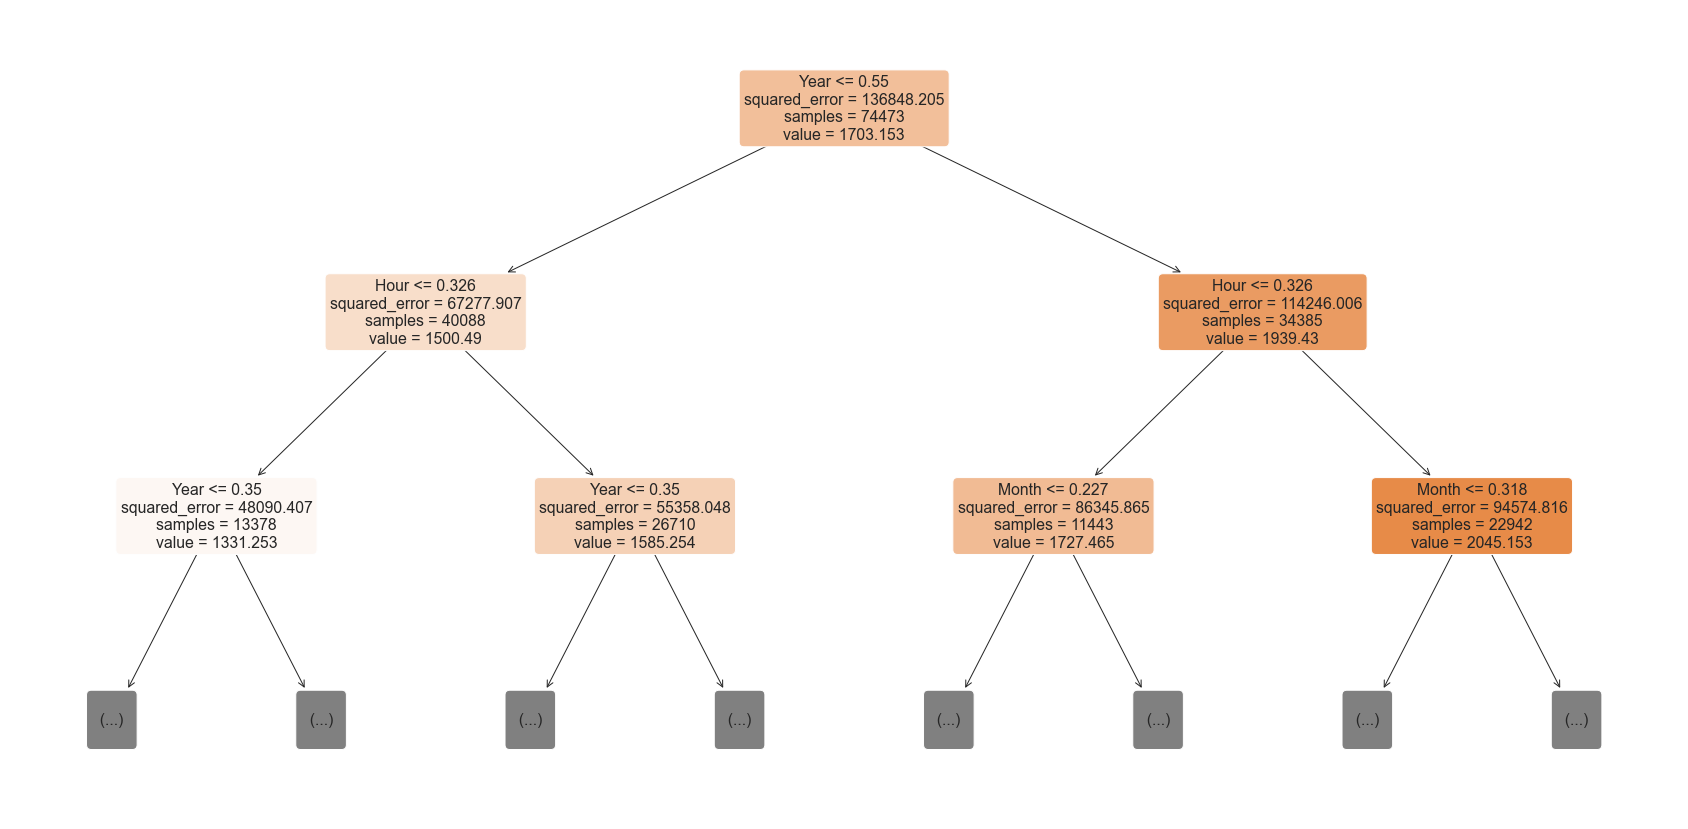

In [76]:
plt.figure(figsize=(30,15))
plot_tree(te_model,feature_names=train_inputs.columns,filled=True,rounded=True,max_depth=2);

Decision is gratetly affeted by year and hour.

Let's check the depth of the tree that was created

In [77]:
te_model.tree_.max_depth

3

We can also display the tree as text, which can be easier to follow for deeper trees.

In [78]:
tree_text = export_text(te_model,feature_names=list(train_inputs.columns),max_depth=10)

In [79]:
# Display the first few lines
print(tree_text[:2000])

|--- Year <= 0.55
|   |--- Hour <= 0.33
|   |   |--- Year <= 0.35
|   |   |   |--- value: [1280.43]
|   |   |--- Year >  0.35
|   |   |   |--- value: [1429.28]
|   |--- Hour >  0.33
|   |   |--- Year <= 0.35
|   |   |   |--- value: [1527.04]
|   |   |--- Year >  0.35
|   |   |   |--- value: [1697.70]
|--- Year >  0.55
|   |--- Hour <= 0.33
|   |   |--- Month <= 0.23
|   |   |   |--- value: [1532.39]
|   |   |--- Month >  0.23
|   |   |   |--- value: [1792.35]
|   |--- Hour >  0.33
|   |   |--- Month <= 0.32
|   |   |   |--- value: [1914.88]
|   |   |--- Month >  0.32
|   |   |   |--- value: [2109.38]



In [80]:
#Display the feature importance

te_model.feature_importances_

array([0.6935475 , 0.06134871, 0.        , 0.        , 0.24510379,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [81]:
#Visualize the feature importance

importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': te_model.feature_importances_
}).sort_values('importance', ascending=False)

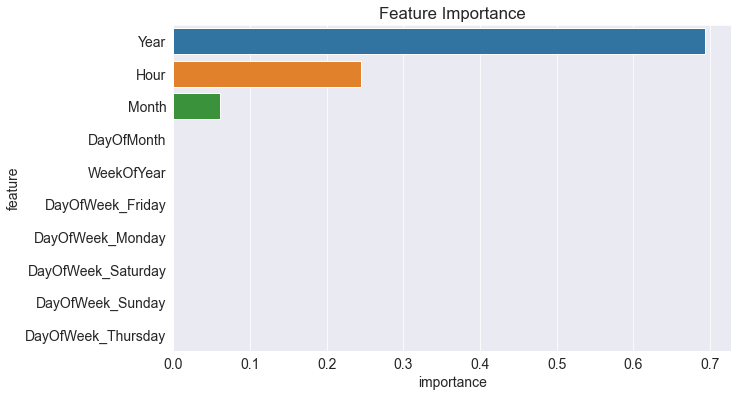

In [82]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

From the above graph we can conclude that Year contributes most to the change of energy.

**Hyperparameter Tuning**

There are many hyperparameters in DecisionTree model, and these together influence the performance of the model. In this case, finding the best one from finite combinations is needed. And we choose 'min_samples_leaf', 'max_depth', 'min_samples_split', 'max_features'.

In [83]:
def test_params(**params):  
    model = DecisionTreeRegressor(random_state=123, **params).fit(train_inputs,train_targets)
    train_error = 1 - model.score(train_inputs, train_targets)
    val_error = 1 - model.score(val_inputs,val_targets)
    return train_error, val_error

In [84]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_error, val_error = test_params(**params)
        train_errors.append(train_error)
        val_errors.append(val_error)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

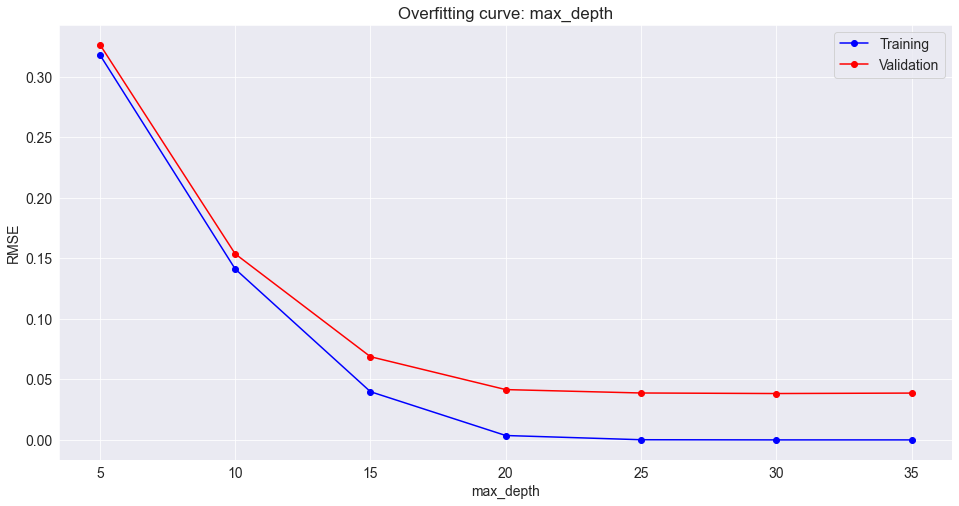

In [85]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

When the max_depth 15, loss is low and there is no issue of overfitting and underfitting.

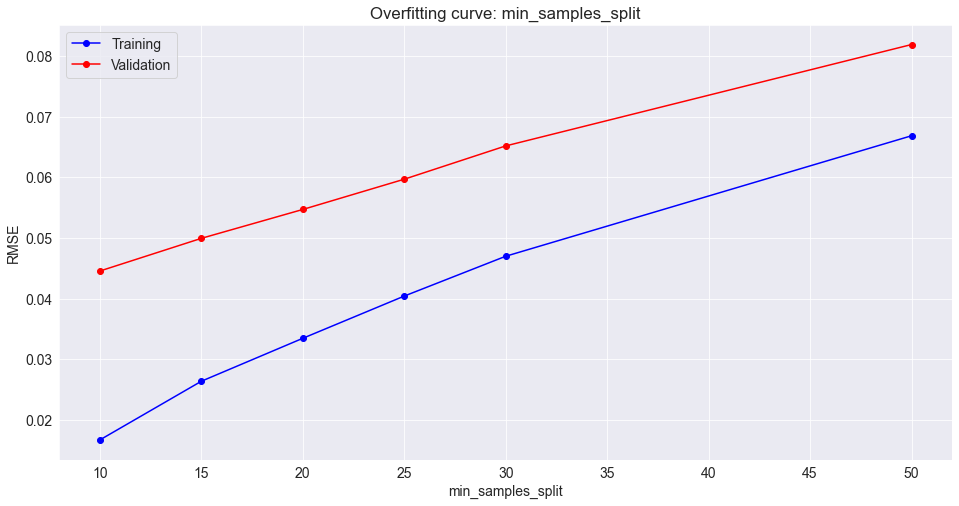

In [86]:
test_param_and_plot('min_samples_split', [10,15,20,25,30,50])

when min_samples_split is high, the loss is also high. So it is better to take low value for this parameter.

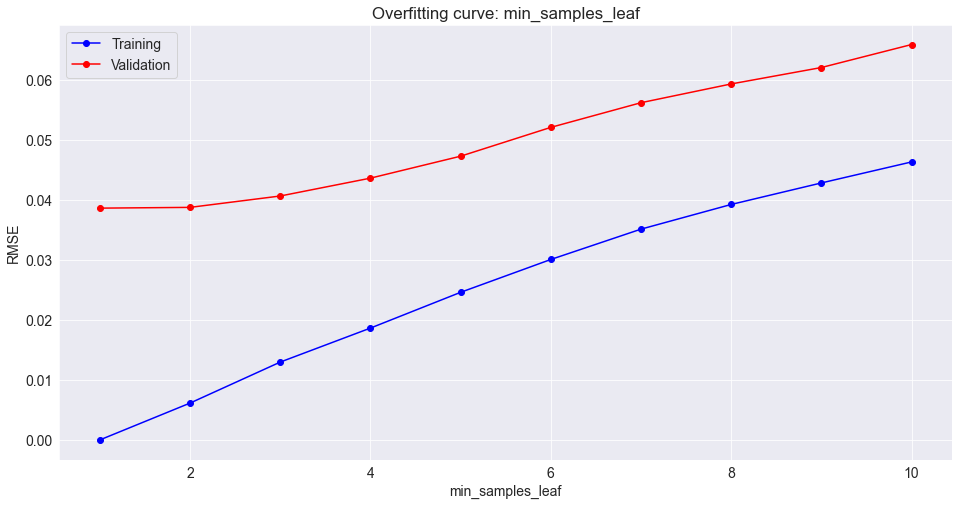

In [87]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Here is the same result like min_samples_split.

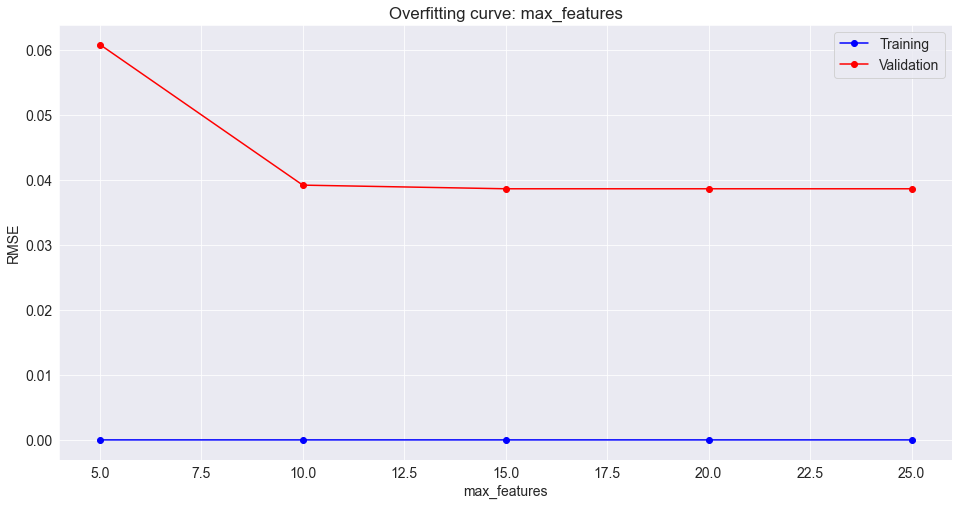

In [88]:
test_param_and_plot('max_features', [5,10,15,20,25])

We will take max_feature as 10 because in this point there is no issue of overfitting and loss is minimum.

From the above testing of parameters, the follwoing values of parameters were found to be the best which minimizes the validation error.

- max_depth=15
- max_features=10
- min_samples_leaf=2
- min_samples_split=10

In [89]:
te_model = DecisionTreeRegressor(random_state=42,
                                max_depth=15,
                                max_features=10,
                                max_leaf_nodes=400,
                                min_samples_leaf=2,
                                min_samples_split=10).fit(train_inputs,train_targets)

In [90]:
te_preds = te_model.predict(val_inputs)

In [91]:
mse_and_r_square(te_model,te_preds)

The Mean Square Error(MSE) is:  140.72657394315254
R square is: 0.8528608894000209


Loss is 140 and R2 is 85%, from this we can say that our model is performing very well by taking these parameters.Let's check overfitting and underfitting.

In [92]:
check_fittings(te_model)

The RMSE loss for the training set is 137.1514.
The RMSE loss for the validation set is 140.7266.


Above values are quite comparable means there is no question of overfitting and underfitting.

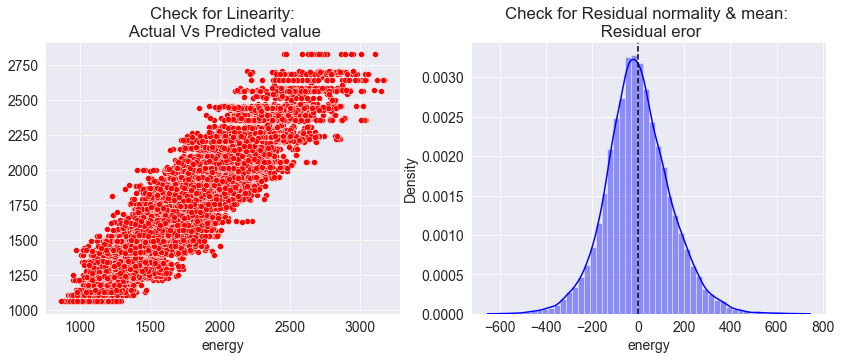

In [93]:
check_linearity_residual_normality(te_preds)

- Actual vs Predicted plot is linear so we can conclude that model is well fitted.
- The residual mean is zero and residual error plot is normal shape.

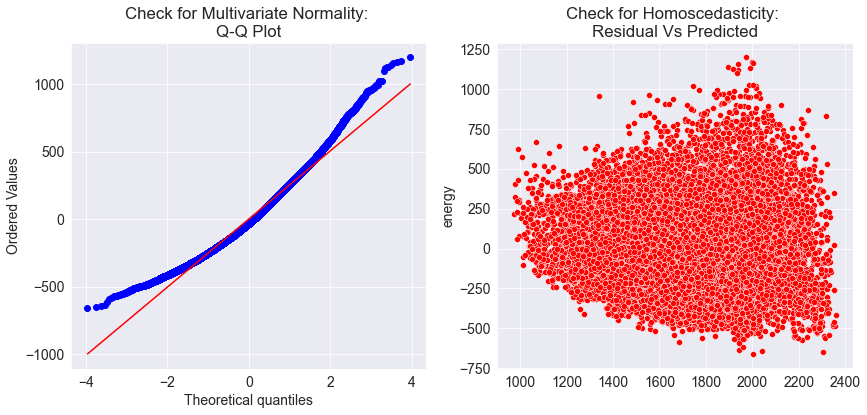

In [94]:
qq_and_homoscedasticity(te_preds)

Q-Q plot shows as value greater than 1000 trends to increase. So we have to try other model.

In [95]:
predict_and_submit(te_model, "dtmodel.csv")

row_id       energy
0       94993  1807.223871
1       94994  1807.223871
2       94995  1613.168895
3       94996  1613.168895
4       94997  1613.168895
...       ...          ...
26299  121292  2460.556739
26300  121293  2460.556739
26301  121294  2230.973621
26302  121295  2230.973621
26303  121296  2230.973621

[26304 rows x 2 columns]

## 5.Random Forest

In [96]:
ra_model = RandomForestRegressor(n_jobs=-1, random_state=42).fit(train_inputs,train_targets)

In [97]:
ra_preds = ra_model.predict(val_inputs)

In [98]:
mse_and_r_square(ra_model,ra_preds)

The Mean Square Error(MSE) is:  49.78550401960152
R square is: 0.9815845763802384


Loss is 206 and R2 is 68.39%. R2 is low means it does not fit well. We can improve our model by applying different parameters.

In [99]:
check_fittings(ra_model)

The RMSE loss for the training set is 19.5644.
The RMSE loss for the validation set is 49.7855.


Above values are quite comparable. There is no issue of overfitting and underfitting.

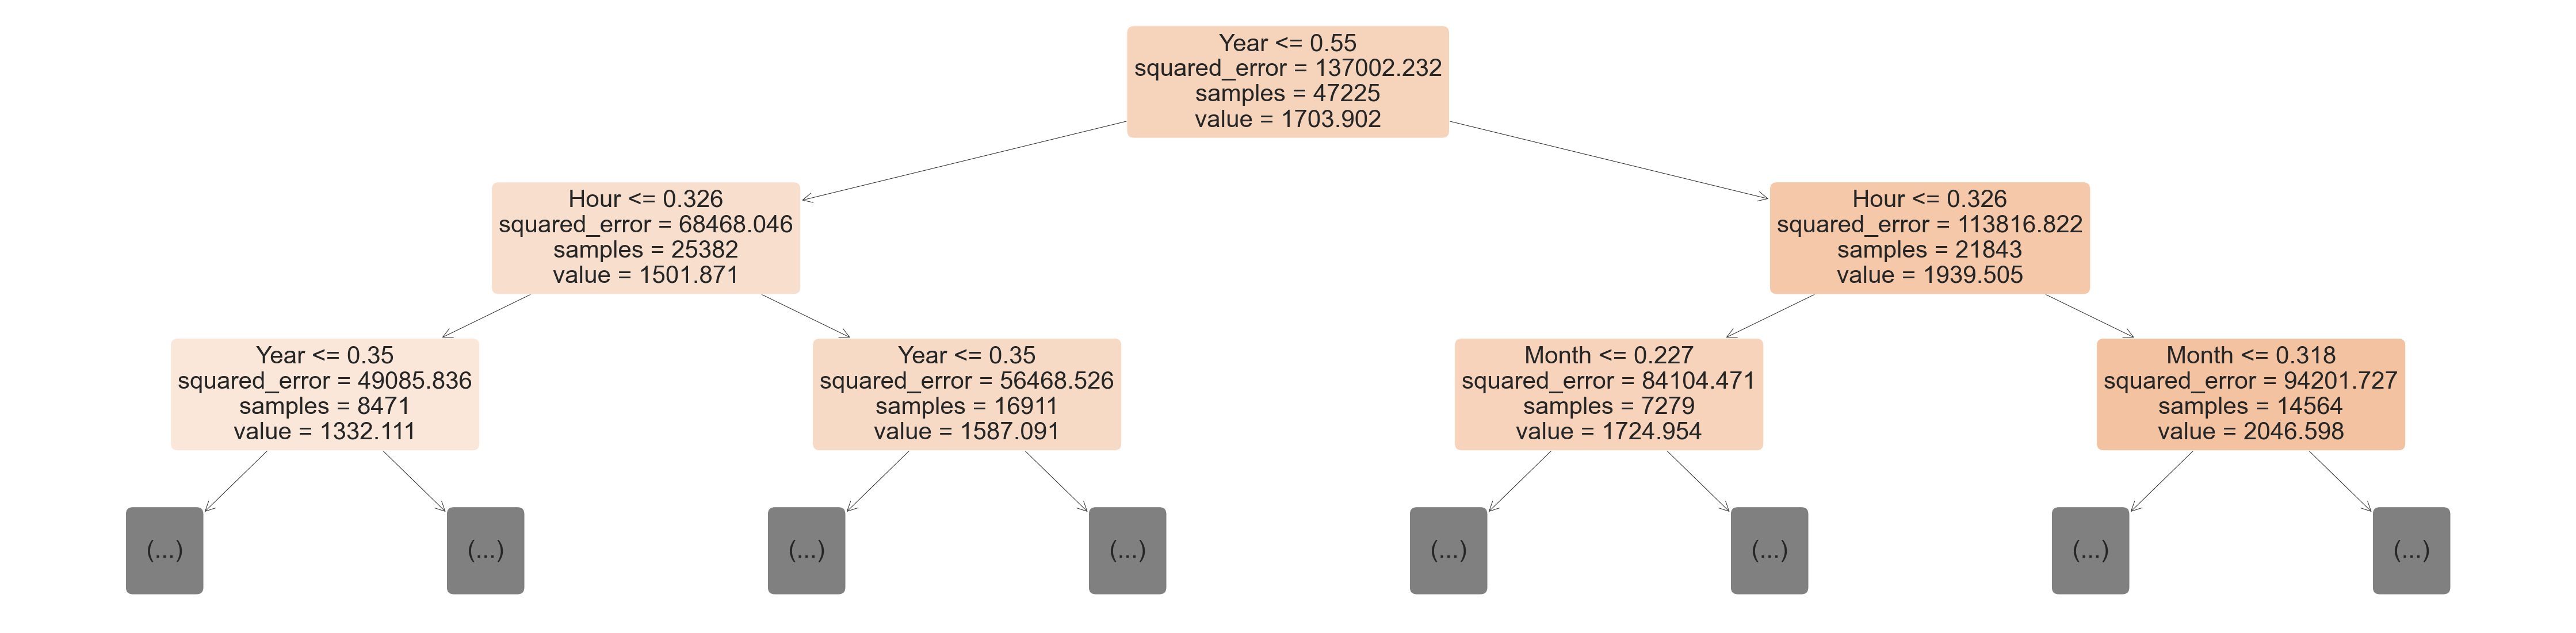

In [100]:
plt.figure(figsize=(80,20))
plot_tree(ra_model.estimators_[1], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True);

In [101]:
len(ra_model.estimators_)

100

In [102]:
#Visualize feature importance

importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': ra_model.feature_importances_
}).sort_values('importance', ascending=False)

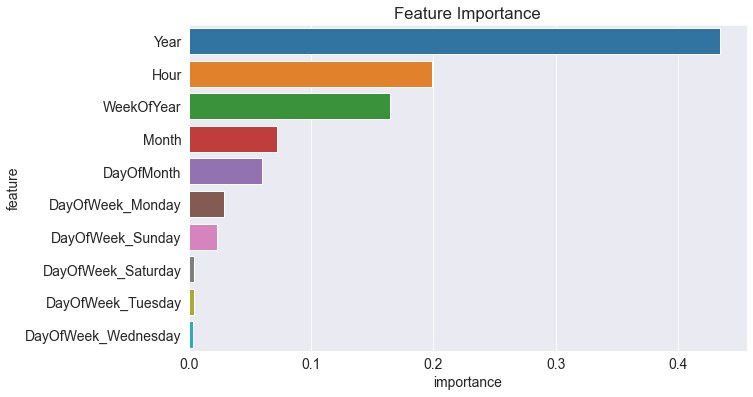

In [103]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

The reusults look similar to the DecisionTree model.

**Hyperparameter Tuning**

Same as decision tree, we choose 'n_estimators', 'max_depth', 'min_samples_split', 'max_features'.

In [104]:
def test_params(**params):  
    model = RandomForestRegressor(random_state=123,n_jobs=-1, **params).fit(train_inputs,train_targets)
    train_error = 1 - model.score(train_inputs, train_targets)
    val_error = 1 - model.score(val_inputs,val_targets)
    return train_error, val_error

In [105]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_error, val_error = test_params(**params)
        train_errors.append(train_error)
        val_errors.append(val_error)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

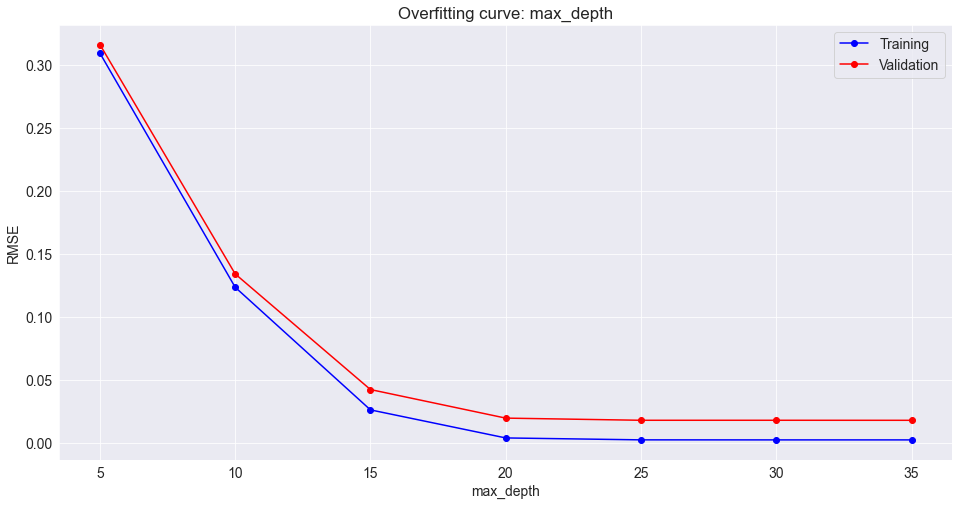

In [106]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

When the max_depth 15, loss is low and there is no issue of overfitting and underfitting.

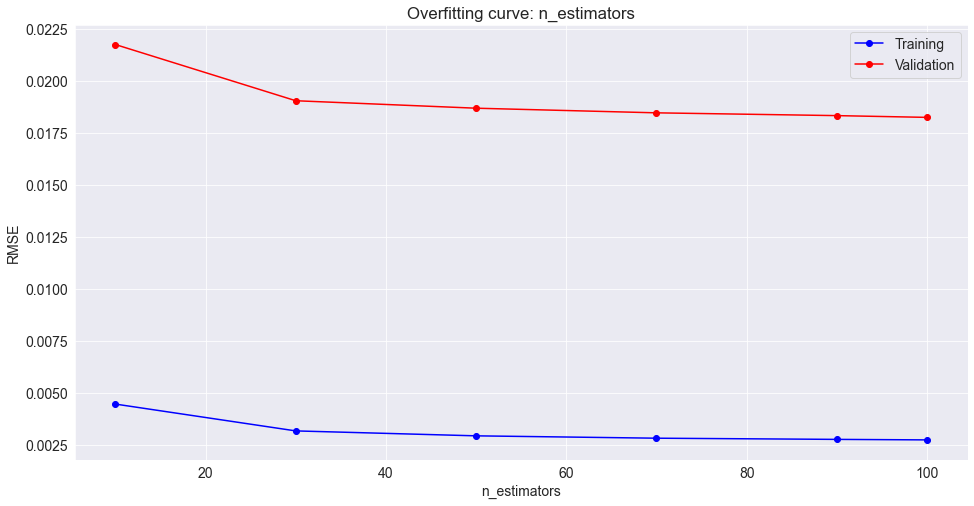

In [107]:
test_param_and_plot('n_estimators', [10, 30, 50, 70, 90, 100])

This graph shows we can any parameter after 30.

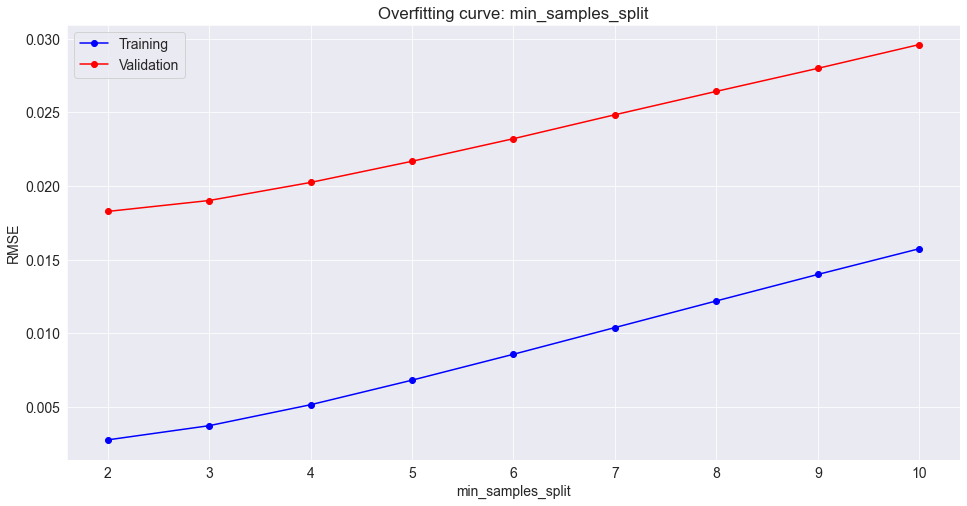

In [108]:
test_param_and_plot('min_samples_split', [2, 3, 4, 5, 6, 7, 8, 9, 10])

Same as decision tree, min_samples_split is high, the loss is also high.

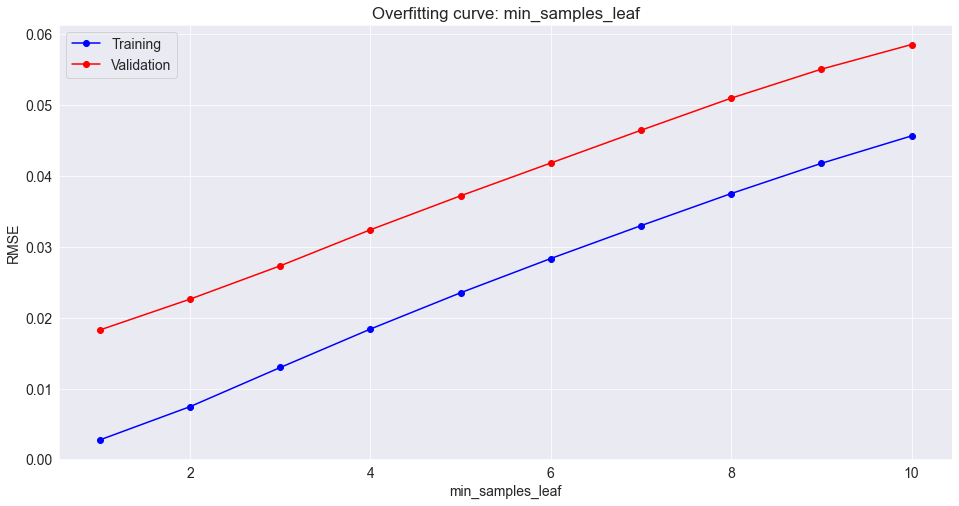

In [109]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Same case as min_samples_split.

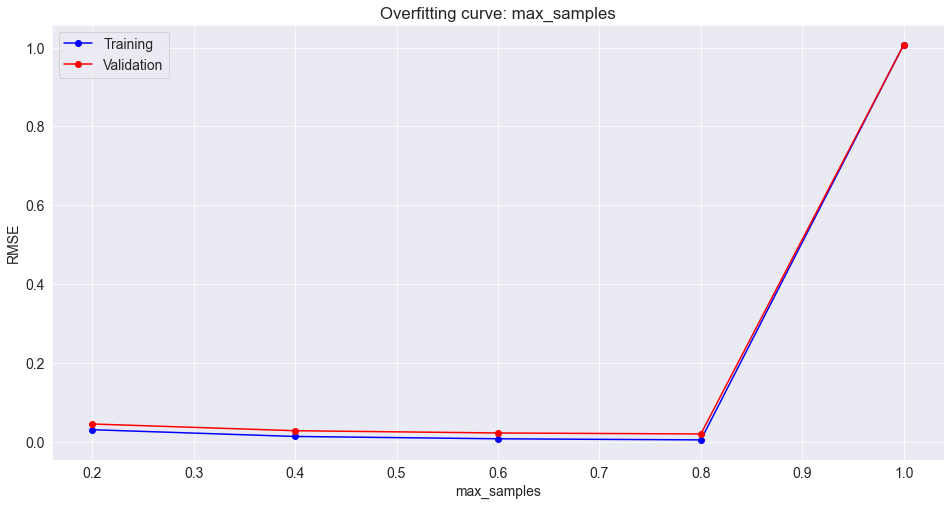

In [110]:
test_param_and_plot('max_samples', [0.2, 0.4, 0.6, 0.8, 1])

We can choose max_sample from 0.2 from 0.8.

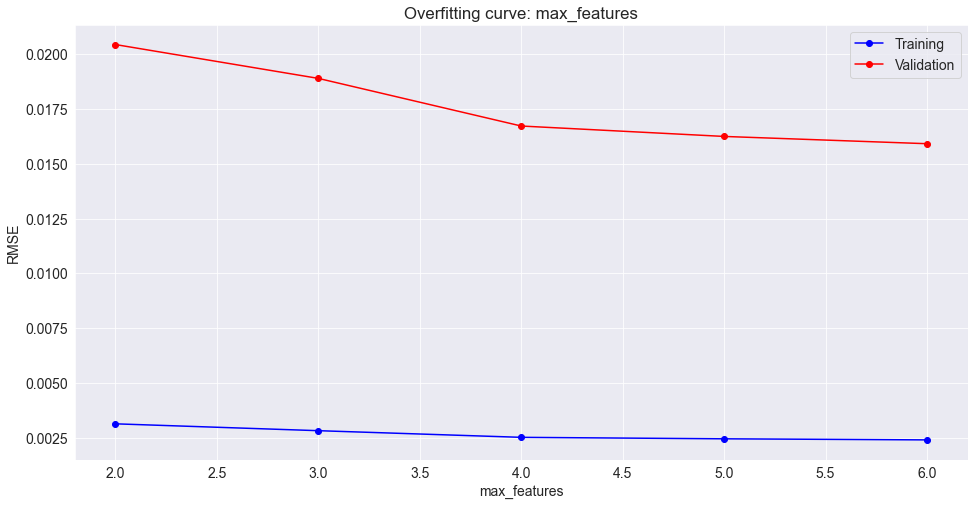

In [111]:
test_param_and_plot('max_features', [2, 3, 4, 5, 6])

6 is good for max_feature because here we can see minimum loss.

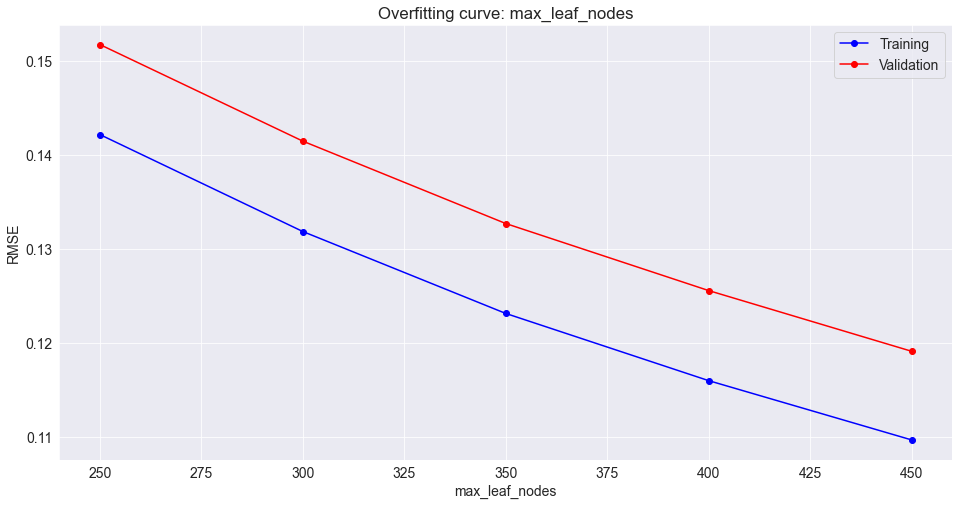

In [112]:
test_param_and_plot('max_leaf_nodes', [250,300,350,400,450])

Max_leaf_nodes increases, loss decreases.

In [113]:
ra_model = RandomForestRegressor(random_state=42,
                                 n_jobs=-1,
                                max_depth=15,
                                max_features=6,
                                max_leaf_nodes=500,
                                min_samples_leaf=2,
                                min_samples_split=2,
                                max_samples=0.8).fit(train_inputs,train_targets)

In [114]:
ra_preds = ra_model.predict(val_inputs)

In [115]:
mse_and_r_square(ra_model,ra_preds)

The Mean Square Error(MSE) is:  123.16426349333672
R square is: 0.887294444072398


Loss is 123.16 and R2 is 88% which is preety good.

In [116]:
check_fittings(ra_model)

The RMSE loss for the training set is 119.2023.
The RMSE loss for the validation set is 123.1643.


Loss for the training and test set is quite comparable.

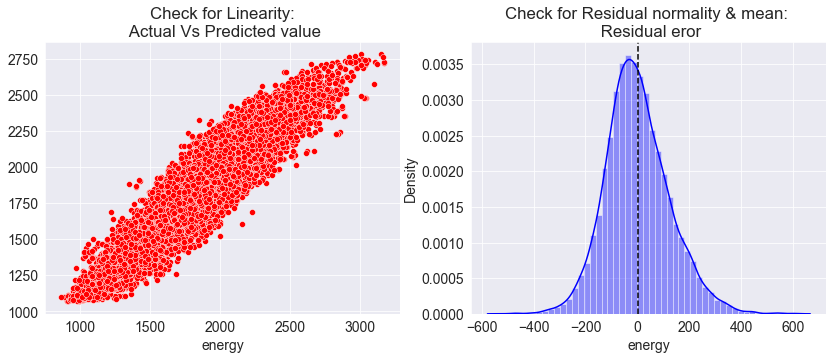

In [117]:
check_linearity_residual_normality(ra_preds)

Same case as decision tree.

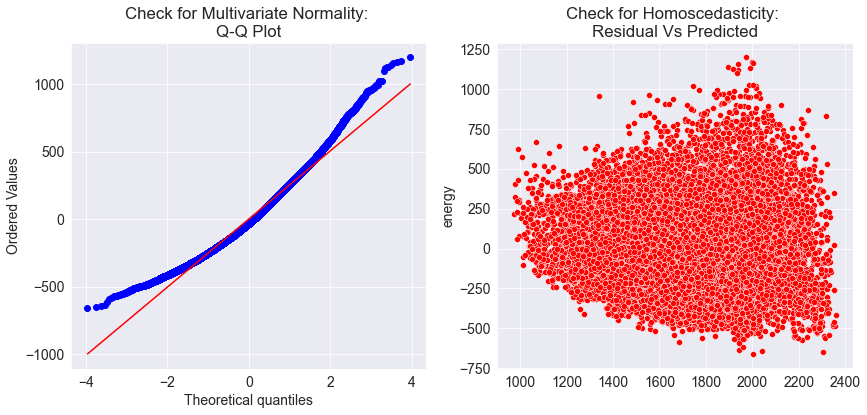

In [118]:
qq_and_homoscedasticity(ra_preds)

Same case as decision tree.

In [180]:
predict_and_submit(ra_model, "random.csv")

row_id       energy
0       94993  1810.281222
1       94994  1733.516519
2       94995  1627.926439
3       94996  1619.575582
4       94997  1619.575582
...       ...          ...
26299  121292  2523.415773
26300  121293  2510.290268
26301  121294  2402.704990
26302  121295  2375.352489
26303  121296  2303.218501

[26304 rows x 2 columns]

## 6.XGBOOST

In [119]:
xg_Model = XGBRegressor(random_state=123).fit(train_inputs,train_targets)

In [120]:
xg_preds = xg_Model.predict(val_inputs)

In [121]:
mse_and_r_square(xg_Model,xg_preds)

The Mean Square Error(MSE) is:  85.82578162504102
R square is: 0.9452717663218093


Loss is 85 and R2 is 94 which is preety good. Now we will check overfitting and underfitting issue.

In [122]:
check_fittings(xg_Model)

The RMSE loss for the training set is 80.7713.
The RMSE loss for the validation set is 85.8258.


Both the values are quite comparable. So there is no overfitting issue.

In [123]:
#Visualize feature importance

importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': xg_Model.feature_importances_
}).sort_values('importance', ascending=False)

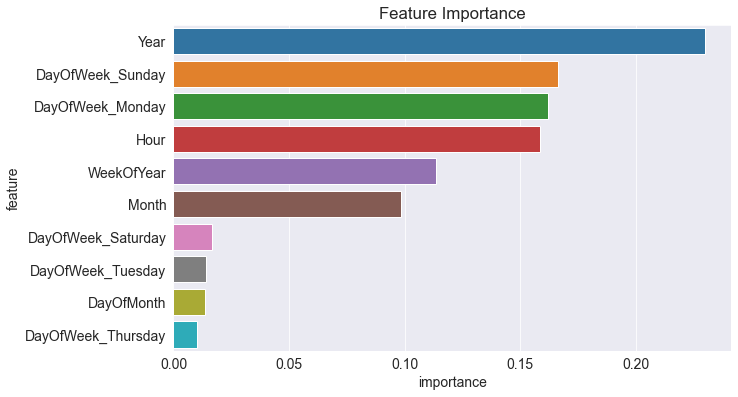

In [124]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

From the above graph we can conclude that Year contributes most to the change of energy.

**Hyperparameter Tuning**

we choose 'n_estimators', 'max_depth', 'Learning_rate','reg_alpha', 'reg_lambda' for tuning.

In [125]:
def test_params(**params):  
    model = XGBRegressor(random_state=123,n_jobs=-1, **params).fit(train_inputs,train_targets)
    train_error = 1 - model.score(train_inputs, train_targets)
    val_error = 1 - model.score(val_inputs,val_targets)
    return train_error, val_error

In [126]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_error, val_error = test_params(**params)
        train_errors.append(train_error)
        val_errors.append(val_error)
    plt.figure(figsize=(16,8))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

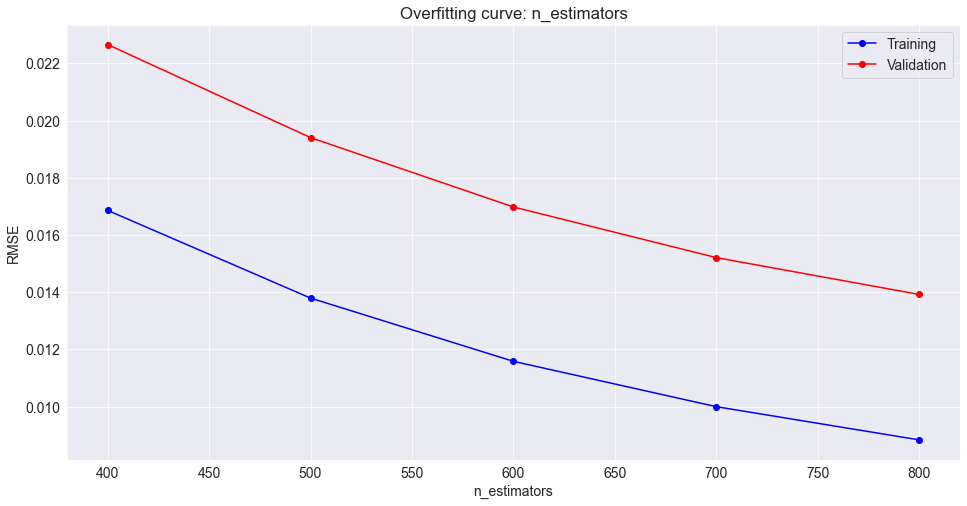

In [127]:
test_param_and_plot('n_estimators', [400,500,600,700,800])

When n_estimators is high, loss is low.

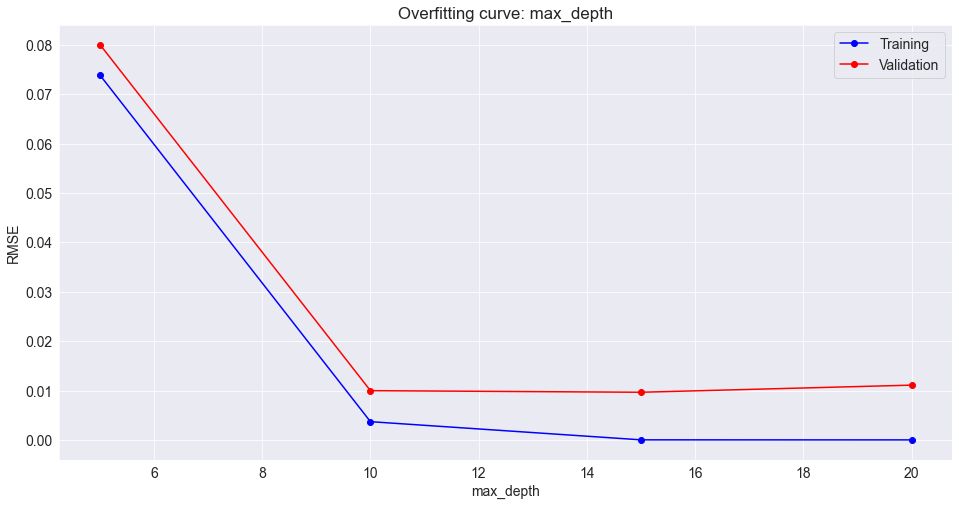

In [128]:
test_param_and_plot('max_depth', [5, 10, 15, 20])

When the max_depth 10, loss is low and there is no issue of overfitting and underfitting.

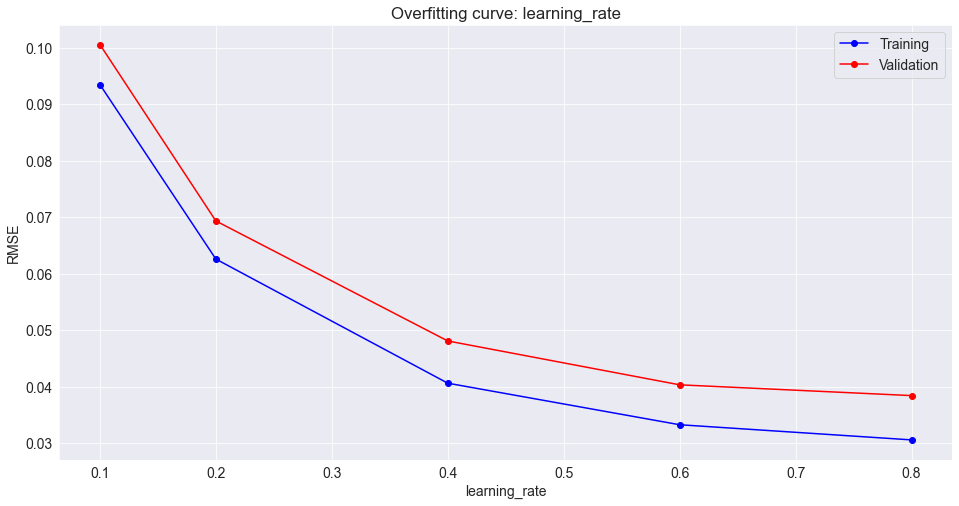

In [129]:
test_param_and_plot('learning_rate', [0.1, 0.2, 0.4, 0.6, 0.8])

0.8 is the best for learning rate because here the loss is minimum.

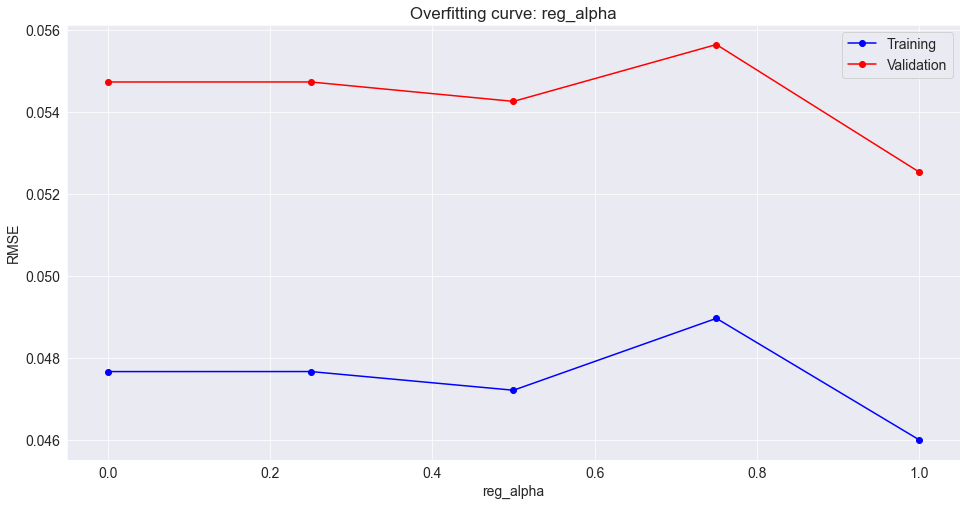

In [130]:
test_param_and_plot('reg_alpha', [0, 0.25, 0.5, 0.75, 1])

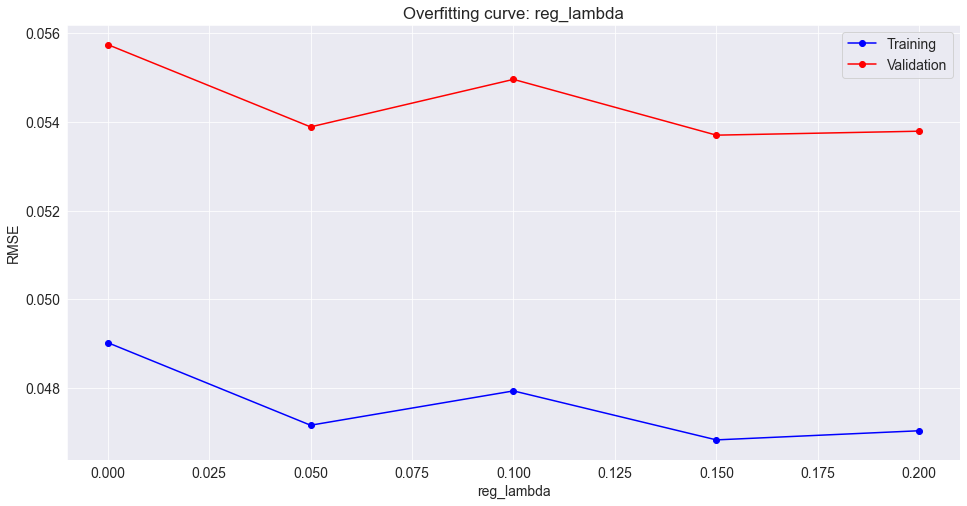

In [131]:
test_param_and_plot('reg_lambda', [0, 0.05, 0.1, 0.15, 0.2])

- max_depth: 10

- n_estimators: 800

- learning_rate: 0.8

- reg_alpha: 0 (default)

- reg_lambda:1 (default)

In [198]:
xg_Model = XGBRegressor(random_state=123,
                       n_estimators=200,
                       max_depth=3,
                       learning_rate=0.2,
                       max_leaves=100,
                       subsample=0.9,
                       colsample_bytree=0.7,
                       booster="gbtree",
                       num_parallel_tree=25).fit(train_inputs,train_targets)                       

In [199]:
xg_preds = xg_Model.predict(val_inputs)

In [200]:
mse_and_r_square(xg_Model,xg_preds)

The Mean Square Error(MSE) is:  129.71041516899948
R square is: 0.8749955147753965


In [201]:
check_fittings(xg_Model)

The RMSE loss for the training set is 128.5268.
The RMSE loss for the validation set is 129.7104.


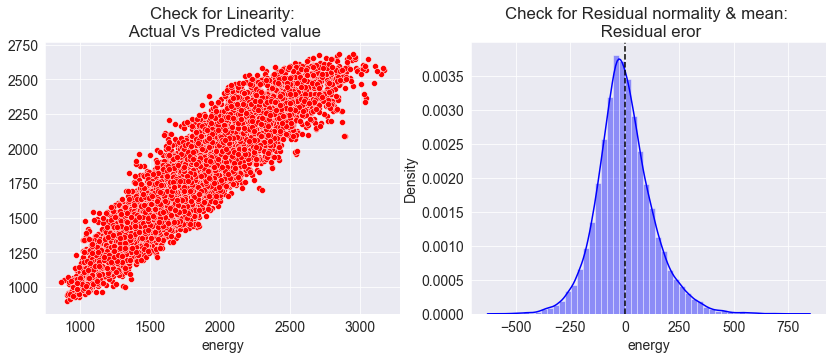

In [206]:
check_linearity_residual_normality(xg_preds)

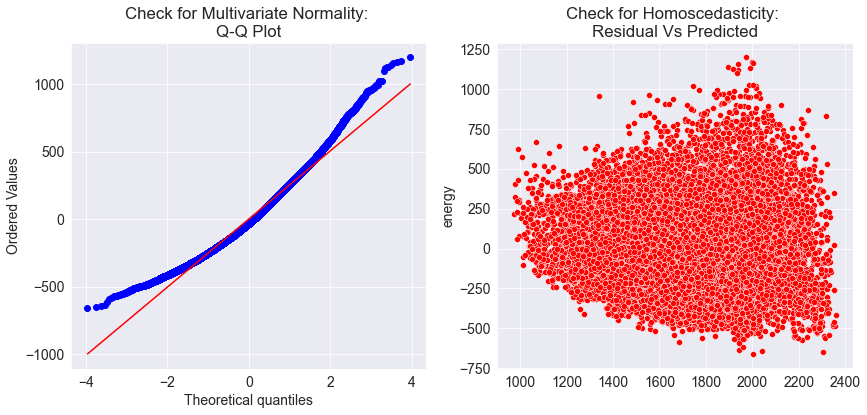

In [202]:
qq_and_homoscedasticity(xg_preds)

**Assumptions**

- In our model the actual vs predicted plot is linear.
- The residual mean is zero and residual error plot is normally distributed
- Q-Q plot shows value greater than 1000 trends to increase

In [203]:
predict_and_submit(xg_Model, "xgmodel1.csv")

row_id       energy
0       94993  1740.658447
1       94994  1639.023926
2       94995  1587.047119
3       94996  1533.809570
4       94997  1513.933350
...       ...          ...
26299  121292  2521.683105
26300  121293  2471.007812
26301  121294  2436.806641
26302  121295  2384.757324
26303  121296  2248.236816

[26304 rows x 2 columns]

## <font color='green'>Model Comparision</font>

**Linear Regression**

- RMSE for Training set: 254.41
- RMSE for Validation set: 255.67
- R2 : 51%

**Ridge Regression**

- RMSE for Training set: 254.41
- RMSE for Validation set: 255.67
- R2 : 51%

**Ridge Regression**

- RMSE for Training set: 254.41
- RMSE for Validation set: 255.67
- R2 : 51%

**Decision Trees Regressor**

- RMSE for Training set: 137.1514
- RMSE for Validation set: 140.726
- R2 : 85%

**Random Forest Regressor**

- RMSE for Training set: 119.2023
- RMSE for Validation set: 123.1643
- R2 : 88%

**XGBRegressor**

- RMSE for Training set: 128.5268
- RMSE for Validation set: 129.7104
- R2 : 87%

## Conclusions

Following inferences and conclusions can be drawn from the the analysis of the data:

- Energy consumption is increasing every year.
- Year, Month and Hour are major contributing factor in the energy.
- RandomForestRegressor and XGBRegressor, both are performing good. But we will select XGBRegressor because with this model we are getting minimum loss in original dataset.